# Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Pip Installs

In [2]:
!pip install torchsummary
!pip install albumentations

# Imports



In [3]:
import time
from torchsummary import summary
from torch.utils.data import DataLoader
import time
import sys
sys.path.append('/content/gdrive/My Drive/EVA/EndGame/Utils/')
from models import *
from utils import *
from loss import *
from dataloader.serialize_filepaths import *
from dataloader.data_loader import *
from train import *
from config import *
import validation as test
from albumentation import *
from albumentations import Normalize, HorizontalFlip, VerticalFlip, Rotate, Cutout, PadIfNeeded, RandomCrop, Flip, Resize

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Move dataset to colab
This significantly increases execution time, since reading from drive is huge time consuming




In [8]:
# start_time = time.time()
# !mkdir dataset_zip
# !mkdir dataset
# !cp -r "/content/gdrive/My Drive/EVA/15A/dataset/fg_bg.zip" "/content/dataset_zip/"
# !cp -r "/content/gdrive/My Drive/EVA/15A/dataset/dense_depth.zip" "/content/dataset_zip/"
# !cp -r "/content/gdrive/My Drive/EVA/15A/dataset/fg_bg_mask.zip" "/content/dataset_zip/"
# !cp -r "/content/gdrive/My Drive/EVA/15A/dataset/bg" "/content/dataset/"
# !unzip -q "/content/dataset_zip/fg_bg.zip" -d "/content/dataset/fg_bg"
# !unzip -q "/content/dataset_zip/fg_bg_mask.zip" -d "/content/dataset/fg_bg_mask"
# !unzip -q "/content/dataset_zip/dense_depth.zip" -d "/content/dataset/dense_depth"
# end_time = time.time()
# print("Time to move data to colab is ", (end_time-start_time)/60)

Time to move data to colab is  5.205622386932373


# Serialize Dataset paths

* Serialize Datapaths and Store it on initial read
* Once pickling is done, this can be commented for further runs
* This to reduce the time in framing the dataset paths


In [ ]:
# datasetPaths = {"bg":"/content/dataset/bg",
#                 "fg_bg":"/content/dataset/fg_bg",
#                 "fg_bg_mask":"/content/dataset/fg_bg_mask",
#                 "dense_depth":"/content/dataset/dense_depth"}

# serialize_filepaths_data(datasetPaths, "/content/gdrive/My Drive/EVA/15A/")

# Model
U2Net
* Total params: 1,769,306




In [4]:
device = getDevice()
print(device)
model = U2NETP().to(device)
model.aux_logits=False
summary(model, input_size=(6, 96, 96))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           3,520
       BatchNorm2d-2           [-1, 64, 96, 96]             128
              ReLU-3           [-1, 64, 96, 96]               0
          REBNCONV-4           [-1, 64, 96, 96]               0
            Conv2d-5           [-1, 16, 96, 96]           9,232
       BatchNorm2d-6           [-1, 16, 96, 96]              32
              ReLU-7           [-1, 16, 96, 96]               0
          REBNCONV-8           [-1, 16, 96, 96]               0
         MaxPool2d-9           [-1, 16, 48, 48]               0
           Conv2d-10           [-1, 16, 48, 48]           2,320
      BatchNorm2d-11           [-1, 16, 48, 48]              32
             ReLU-12           [-1, 16, 48, 48]               0
         REBNCONV-13           [-1, 16, 48, 48]               0
        MaxPool2d-14           [-1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


# Data Loader


*   Batch Size - 64
*   Initial Image size - 64*64



In [5]:
bg_transforms_list = [Resize(64,64)]
fg_bg_transforms_list = [Resize(64,64)]
fg_bg_mask_transforms_list = [Resize(64,64)]
dense_depth_transforms_list = [Resize(64,64)]


train_transforms = {"bg":getAlbumTransformation(bg_transforms_list), "fg_bg":getAlbumTransformation(fg_bg_transforms_list)}
train_target_transforms = {"fg_bg_mask":getAlbumTransformation(fg_bg_mask_transforms_list), "dense_depth":getAlbumTransformation(dense_depth_transforms_list)}

train_dataset, test_dataset = EndGameTrainTestDataSet("/content/gdrive/My Drive/EVA/15A/c_dataset_filepaths.pickle", "/content/dataset/", train_split=70, 
                                             train_transforms=train_transforms, train_target_transforms=train_target_transforms, 
                                             test_transforms=train_transforms, test_target_transforms=train_target_transforms)
print("Train dataset length ",len(train_dataset))
print("Test dataset lenght ", len(test_dataset))
BATCH_SIZE = 64
trainloader = DataLoader(train_dataset, num_workers=8, batch_size=BATCH_SIZE)
testloader = DataLoader(test_dataset, num_workers=8, batch_size=BATCH_SIZE)



Train dataset length  280000
Test dataset lenght  120000


# Dataset Samples


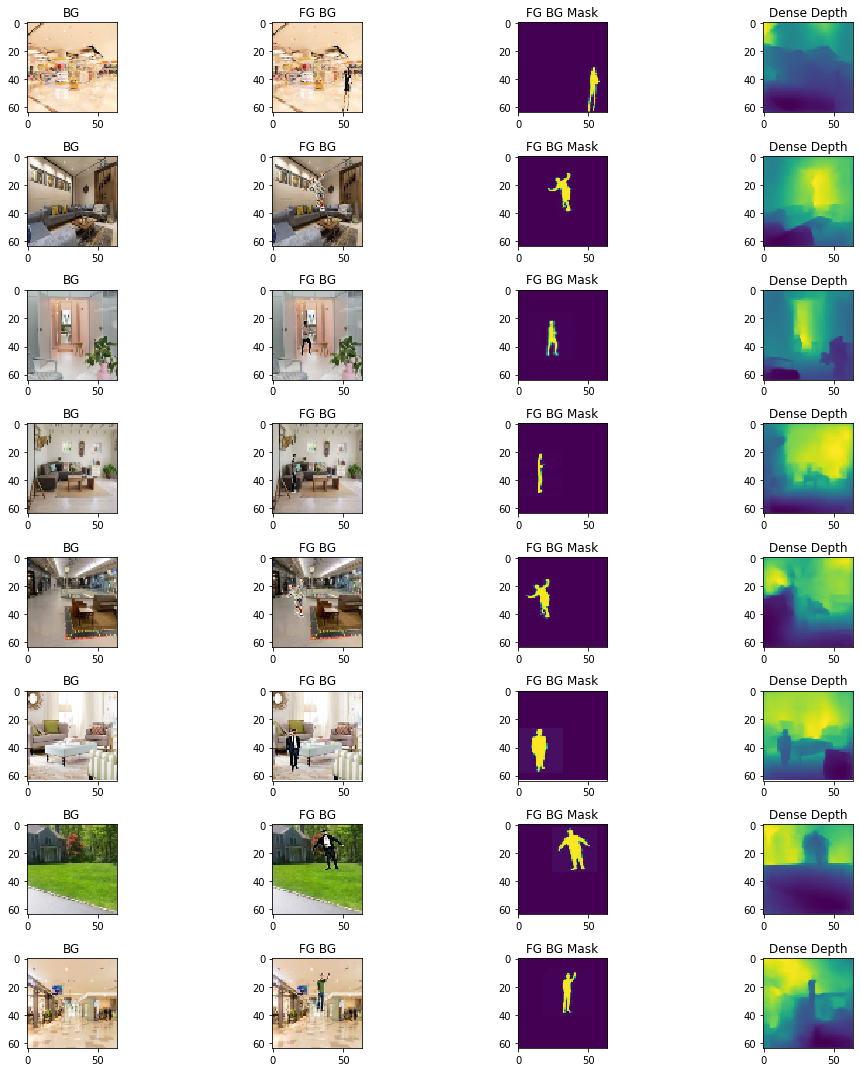

In [ ]:
plot_endgame_images(next(iter(trainloader)), 8)

# Set loss, epochs and other hyper parameters

In [6]:
EPOCHS = 10
from torch.optim.lr_scheduler import OneCycleLR
max_lr = 0.01
div_factor = 10
min_lr = max_lr/div_factor
depth_criterion = muti_bce_loss_fusion
seg_criterion = muti_bce_loss_fusion
optimizer = optim.Adam(model.parameters(), lr=min_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(trainloader), epochs=EPOCHS, pct_start=0.5, div_factor=div_factor, final_div_factor=1, anneal_strategy='linear',
                       cycle_momentum=False)
modelName = "segment_depth"
modelDir = "/content/gdrive/My Drive/EVA/EndGame/saved_models/"

# Train and Test

In [ ]:
for epoch in range(EPOCHS):
  start_time = time.time()
  print('EPOCH : ', epoch, ' LR : ', scheduler.get_lr())
  train(model, device, trainloader, optimizer, depth_criterion, seg_criterion, scheduler=scheduler)
  test.__test(model, device, testloader, depth_criterion, seg_criterion)
  torch.save(model.state_dict(), modelDir+modelName+".pt")
  end_time = time.time()
  print("--- %s Mins ---" % int((end_time - start_time)/60))

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/4375 [00:00<?, ?it/s]

EPOCH :  0  LR :  [0.001]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Batch_id=4374 Train set: Loss=4.3440235915047785 Accuracy IOU(Segmentation)=0.8687179126026464 RMSE(Dense depth)=0.08881691098213196  Avg Batch Time=0.3695487976074219 Secs: 100%|██████████| 4375/4375 [28:13<00:00,  2.58it/s]
Batch_id=1874 Test set: Average loss: 4.2791091903686524 Accuracy IOU(Segmentation)=0.9319793257915041 RMSE(Dense depth)=0.0783790647983551  Avg Batch Time=0.164

--- 34 Mins ---
EPOCH :  1  LR :  [0.0028000822894760904]


Batch_id=4374 Train set: Loss=4.265194966670445 Accuracy IOU(Segmentation)=0.9412640682419111 RMSE(Dense depth)=0.07392740994691849  Avg Batch Time=0.36836886405944824 Secs: 100%|██████████| 4375/4375 [28:17<00:00,  2.58it/s]
Batch_id=1874 Test set: Average loss: 4.265570718383789 Accuracy IOU(Segmentation)=0.9442880997917511 RMSE(Dense depth)=0.07349146157503128  Avg Batch Time=0.16271638870239258 Secs): 100%|██████████| 1875/1875 [06:20<00:00,  4.93it/s]
  0%|          | 0/4375 [00:00<?, ?it/s]

--- 34 Mins ---
EPOCH :  2  LR :  [0.004600164578952182]


Batch_id=4374 Train set: Loss=4.2576379946027485 Accuracy IOU(Segmentation)=0.9361398889356173 RMSE(Dense depth)=0.07058954238891602  Avg Batch Time=0.38668084144592285 Secs: 100%|██████████| 4375/4375 [28:03<00:00,  2.60it/s]
Batch_id=1874 Test set: Average loss: 4.257463026682536 Accuracy IOU(Segmentation)=0.9363050891845871 RMSE(Dense depth)=0.07266639173030853  Avg Batch Time=0.1515064239501953 Secs): 100%|██████████| 1875/1875 [06:08<00:00,  5.09it/s]
  0%|          | 0/4375 [00:00<?, ?it/s]

--- 34 Mins ---
EPOCH :  3  LR :  [0.006400246868428271]


Batch_id=4374 Train set: Loss=4.248366326250348 Accuracy IOU(Segmentation)=0.9441930051007414 RMSE(Dense depth)=0.06828390061855316  Avg Batch Time=0.3636047840118408 Secs: 100%|██████████| 4375/4375 [27:47<00:00,  2.62it/s]
Batch_id=1874 Test set: Average loss: 4.267266577911377 Accuracy IOU(Segmentation)=0.9220541801416303 RMSE(Dense depth)=0.07061221450567245  Avg Batch Time=0.15730738639831543 Secs): 100%|██████████| 1875/1875 [06:09<00:00,  5.08it/s]
  0%|          | 0/4375 [00:00<?, ?it/s]

--- 33 Mins ---
EPOCH :  4  LR :  [0.008200329157904362]


Batch_id=4332 Train set: Loss=4.243269832641017 Accuracy IOU(Segmentation)=0.9493333733944699 RMSE(Dense depth)=0.06666585057973862  Avg Batch Time=0.3756260871887207 Secs:  99%|█████████▉| 4333/4375 [27:46<00:16,  2.60it/s]

Buffered data was truncated after reaching the output size limit.

In [10]:
# torch.save(model.state_dict(), modelDir+modelName+".pt")
# model.load_state_dict(torch.load(modelDir+modelName+".pt"))
# model.cuda()

# Results

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


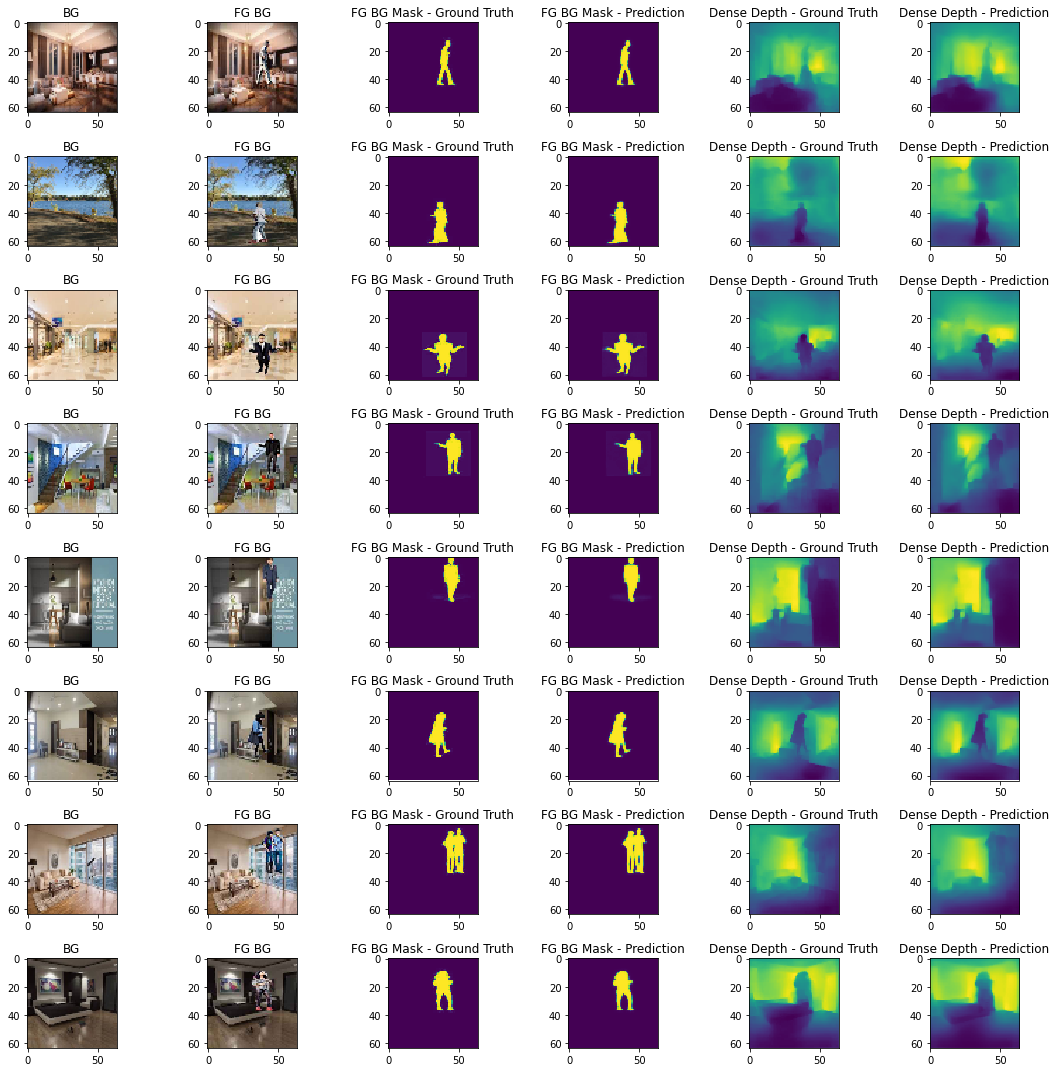

In [9]:
show_predictions(model, testloader, device, noOfImages=8)